In [1]:
%run /eos/project/m/mte/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.2.2.el7.x86_64-x86_64-with-redhat-6.9-Carbon
Your folder is /eos/user/e/esenes/Injection_missteering/2017.08.15
Your IP is 172.17.0.4
2017-11-17 10:57:24
---


In [2]:
# let's start with the matlab data
files = sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.15/data/2017*.mat'))
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

Found 295 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.15/data/2017.08.15.12.39.43.039.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.15/data/2017.08.15.15.29.03.502.mat


## Load the data

In [3]:
myDataFrame = myToolbox.fromMatlabToDataFrame(files,['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1','PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1',
                                                     'PR_BWS_85_V_ROT.Acquisition.value.projDataSet1','PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1',
                                                         'logical_PI_KFA45.K.value',
                                                     'PR_BPM.AcquisitionOrbit.value.position',
                                                    'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                                                    'PR_BCT_ST.Samples.value.samples','PI_KFA45.AQN1.value',
                                                    'PI_KFA45.CCV.value'],verbose=False)

## Load ref kicker settings

In [4]:
refPath = '/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.08.15/refKicker.mat'
scipy.io.whosmat(refPath)
scipy.io.loadmat(refPath)

# refKicker = 

{'__globals__': [],
 '__header__': 'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Aug 10 19:07:28 2017',
 '__version__': '1.0',
 'k': array([[ 0.004381]])}

## Intensity

In [5]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Losses_perc'] = myDataFrame['Intensity'].apply(lambda x: 1-x[:][1780]/np.max(x) )

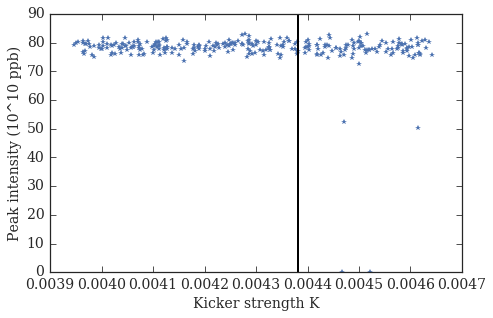

In [6]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'],myDataFrame['Intensity'].apply(lambda x: np.max(x)),'*')
plt.xlabel('Kicker strength K')
plt.ylabel('Peak intensity (10^10 ppb)')
plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

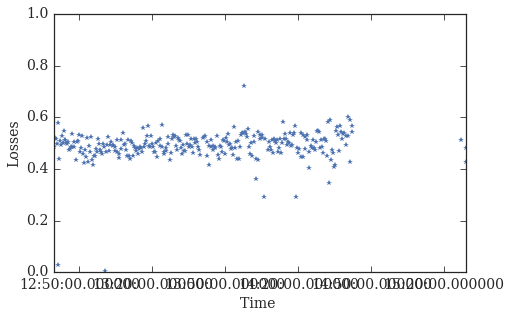

In [7]:
plt.plot(myDataFrame['Losses_perc'],'*')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,1))
plt.xlabel('Time ')
plt.ylabel('Losses')

## BPMs

In [8]:
lenArr = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: len(x))
lenArr[lenArr != 86].index

DatetimeIndex(['2017-08-15 13:23:47.500000'], dtype='datetime64[ns]', freq=None)

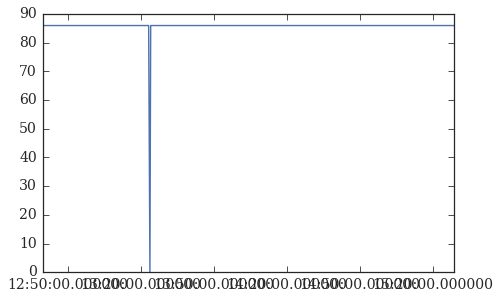

In [9]:
# BPM data cleanup
lenArr = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: len(x))
plt.plot(lenArr)
minVal = np.argmin(lenArr) #adjust it to remove the values != 86 and not only the minimum
myDataFrame.loc[minVal]
myDataFrame = myDataFrame.drop(minVal)

In [10]:
# BPMs
#add field for the first two turns and splitting x and y pickups
myDataFrame['BPMx_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[0:43,0])
myDataFrame['BPMy_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[-43:,0])
myDataFrame['BPMx_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[0:43,1])
myDataFrame['BPMy_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[-43:,1])
# #turn to millimiters and cast in float
myDataFrame['BPMx_turn1'] = myDataFrame['BPMx_turn1'].apply(lambda x: x/10.)
myDataFrame['BPMy_turn1'] = myDataFrame['BPMy_turn1'].apply(lambda x: x/10.)
myDataFrame['BPMx_turn2'] = myDataFrame['BPMx_turn2'].apply(lambda x: x/10.)
myDataFrame['BPMy_turn2'] = myDataFrame['BPMy_turn2'].apply(lambda x: x/10.)
# #add orbit
myDataFrame['Orbit_x'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: x[0:43,1])
myDataFrame['Orbit_y'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: x[-43:,1])
myDataFrame['Orbit_x'] = myDataFrame['Orbit_x'].apply(lambda x: x/10.)
myDataFrame['Orbit_y'] = myDataFrame['Orbit_y'].apply(lambda x: x/10.)

### Calculate the injection oscillation at every BPM

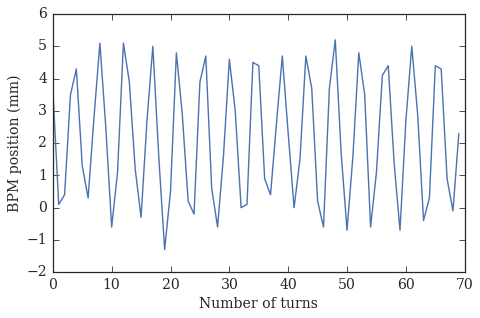

In [11]:
plt.plot(myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[25,0:70]).values[50])
dd = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[25,0:50]).values[50]
plt.xlabel('Number of turns')
plt.ylabel('BPM position (mm)')

Model function: a sin(bx + c) + d
Fit params: a=1.5166445012±0.00724528088172 b= 1.39742444327±1.39784665973e-05 c= 2.29261122395±0.012001996467 d= 2.16333575864±0.00359120631495


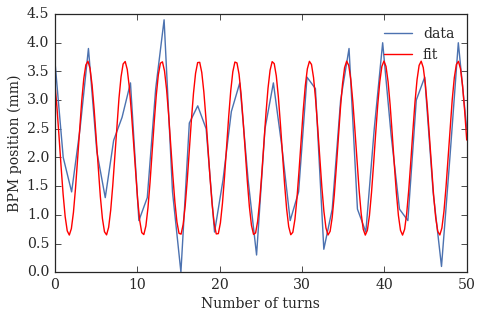

In [12]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, b, c, d):    
    return a*np.sin(b*x + c) + d

xdata = np.linspace(0,50,50)
ydata = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[25,0:50]).values[111]


plt.plot(xdata, ydata,'-',label='data') #factors are to adjust units in the plot

xfit = np.linspace(0,50,200)

p, cov = curve_fit(f_to_fit,xdata,ydata,bounds=([-np.inf, 2.*pi/5, -np.inf, -np.inf],[np.inf,pi/2.,np.inf,np.inf]))
plt.plot(xfit, f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a sin(bx + c) + d'
print 'Fit params: a=' + str(p[0]) + '±' + str(cov[0][0]) + ' b= ' + str(p[1]) + '±' + str(cov[1][1]) + ' c= '+ str(p[2]) + '±' + str(cov[2][2]) + ' d= ' + str(p[3]) + '±' + str(cov[3][3]) 

plt.xlabel('Number of turns')
plt.ylabel('BPM position (mm)')
plt.legend()

In [13]:
# fit an harmonic function through the oscillations and extrapolate the amplitude. 
# possible tunes (non integer part) have been restricted to be between .20 and .25 

from scipy.optimize import curve_fit
def f_to_fit(x, a, b, c, d):
    return a*np.sin(b*x + c) + d

xdata = np.linspace(0,50,50)
myDataFrame['Injection_osc_amplitude'] = np.nan

for k in range(len(myDataFrame)):
    print str(k) + '/' + str(len(myDataFrame))
    ydata = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[25,0:50]).values[k]

    p, cov = curve_fit(f_to_fit,xdata,ydata,bounds=([0, 2.*pi/5, -np.inf, -np.inf],[np.inf,pi/2.,np.inf,np.inf]))
    myDataFrame['Injection_osc_amplitude'].iloc[k] = p[0]

0/294
1/294
2/294


/cvmfs/sft.cern.ch/lcg/views/LCG_91/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/pandas/core/indexing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


3/294
4/294
5/294
6/294
7/294
8/294
9/294
10/294
11/294
12/294
13/294
14/294
15/294
16/294
17/294
18/294
19/294
20/294
21/294
22/294
23/294
24/294
25/294
26/294
27/294
28/294
29/294
30/294
31/294
32/294
33/294
34/294
35/294
36/294
37/294
38/294
39/294
40/294
41/294
42/294
43/294
44/294
45/294
46/294
47/294
48/294
49/294
50/294
51/294
52/294
53/294
54/294
55/294
56/294
57/294
58/294
59/294
60/294
61/294
62/294
63/294
64/294
65/294
66/294
67/294
68/294
69/294
70/294
71/294
72/294
73/294
74/294
75/294
76/294
77/294
78/294
79/294
80/294
81/294
82/294
83/294
84/294
85/294
86/294
87/294
88/294
89/294
90/294
91/294
92/294
93/294
94/294
95/294
96/294
97/294
98/294
99/294
100/294
101/294
102/294


RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

In [ ]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'],myDataFrame['Injection_osc_amplitude'],'.')

In [ ]:
xdata = (myDataFrame['Injection_osc_amplitude'])**2
ydata = myDataFrame['WS_emittance_x']/2.2693651855811541

params, cov_mat = np.polyfit(xdata,ydata,1,full=False,cov=True)

plt.plot(x, params[0]*x+params[1],'r')
print 'fit result: y=' + str(params[0]) + 'x + '+ str(params[1])

plt.plot(xdata,ydata,'.')
x1,x2,y1,y2 = plt.axis()
plt.axis((-1,x2,y1,y2))
plt.xlabel('Injection oscillation amplitude ^2')
plt.ylabel('Geometrical emittance')



In [ ]:
mySlice = myDataFrame.loc[myDataFrame['Injection_osc_amplitude']<1.]

xdata = np.linspace(0,30,30)
def f_to_fit(x, a, b, c, d):
    return a*np.sin(b*x + c) + d

k=19

ydata = mySlice['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[25,0:30]).values[k]

plt.plot(xdata, ydata,'-',label='data') #factors are to adjust units in the plot

xfit = np.linspace(0,30,200)

p, cov = curve_fit(f_to_fit,xdata,ydata,bounds=([0, 2.*pi/5, -np.inf, -np.inf],[np.inf,pi/2.,np.inf,np.inf]))
plt.plot(xfit, f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a sin(bx + c) + d'
print 'Fit params: a=' + str(p[0]) + ' ± ' + str(cov[3][3])

plt.xlabel('Number of turns')
plt.ylabel('BPM position (mm)')
plt.legend()

# calculate the chi square
np.sum(((ydata - f_to_fit(xdata, *p))**2)/ydata)


### calculate the RMS orbit deviation
Use difference between the first and second turn to evaluate the orbit deviation from the reference orbit, where


$$\Delta x_\text{rms} =  \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_\text{turn2} - x_\text{turn1})^2 }$$


excluding the BPM in the bump, that would dominate the estimator.

Same for the deviation from the orbit 

$$\Delta x_\text{rms, orbit} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_\text{turn1} - x_\text{average_orbit_1ms})^2 }$$

In [ ]:
# X plane
mySeries1 = myDataFrame['BPMx_turn1'].apply(lambda x: np.delete(x,17))
mySeries2 = myDataFrame['BPMx_turn2'].apply(lambda x: np.delete(x,17))
myOrbit = myDataFrame['Orbit_x'].apply(lambda x: np.delete(x,17))

BPM_n = 42;

deltaXrms = []
delta_1st_orbit = []
for x in range(mySeries1.values.size) :
    deltaXrms.append( np.sqrt( ( np.sum((mySeries2.values[x] - mySeries1.values[x])**2) )/BPM_n ) )
    delta_1st_orbit.append( np.sqrt( ( np.sum((mySeries1.values[x] - myOrbit.values[x])**2) )/BPM_n ) )
    
myDataFrame['deltaX_2turns'] = deltaXrms
myDataFrame['OrbitX_dev_RMS'] = delta_1st_orbit

# Y plane
mySeries1 = myDataFrame['BPMy_turn1'].apply(lambda x: np.delete(x,17))
mySeries2 = myDataFrame['BPMy_turn2'].apply(lambda x: np.delete(x,17))
myOrbit = myDataFrame['Orbit_y'].apply(lambda x: np.delete(x,17))

BPM_n = 42;

deltaXrms = []
delta_1st_orbit = []
for x in range(mySeries1.values.size) :
    deltaXrms.append( np.sqrt( ( np.sum((mySeries2.values[x] - mySeries1.values[x])**2) )/BPM_n ) )
    delta_1st_orbit.append( np.sqrt( ( np.sum((mySeries1.values[x] - myOrbit.values[x])**2) )/BPM_n ) )
    
myDataFrame['deltaY_2turns'] = deltaXrms
myDataFrame['OrbitY_dev_RMS'] = delta_1st_orbit

In [ ]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'],myDataFrame['deltaX_2turns'].values,'*')

plt.xlabel('Kicker strength K')
plt.ylabel('RMS orbit deviation on first 2 turns(mm)')
plt.title('First two turn RMS orbit difference: X plane')


x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,8))
plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

In [ ]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'],myDataFrame['deltaY_2turns'].values,'*')

plt.xlabel('Kicker strength K')
plt.ylabel('RMS orbit deviation on first 2 turns(mm)')
plt.title('First two turn RMS orbit difference: Y plane')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0.1,.5))
plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

In [ ]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'],myDataFrame['OrbitX_dev_RMS'].values,'*')

plt.xlabel('Kicker strength K')
plt.ylabel('RMS orbit deviation 1st turn-orbit (mm)')
plt.title('First turn RMS orbit difference from closed orbit: X plane')


x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,8))
plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

In [ ]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'],myDataFrame['OrbitY_dev_RMS'].values,'*')

plt.xlabel('Kicker strength K')
plt.ylabel('RMS orbit deviation 1st turn-orbit (mm)')
plt.title('First turn RMS orbit difference from closed orbit: Y plane')


x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0.2,.5))
plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

## Wire scanner

### X plane

In [14]:
# data cleanup
myDataFrame = myDataFrame.drop('2017-08-15 15:26:43.900000')

In [15]:
# Wirescanner
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS65_position'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS65_position_idx'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

In [16]:
#instantiate an array object for the result in the frame
myDataFrame['BWS65_data'] = myDataFrame['BWS65_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS65_data'].iloc[r] = np.interp(pos, myDataFrame['BWS65_position'].iloc[r], myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS65_position_idx'].iloc[r]])  

In [17]:
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_x'] = myDataFrame['BWS65_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_x'] = myDataFrame['WS_fit_results_x'].apply(lambda x: x[0][-1])

### Y plane

In [18]:
# data cleanup
myDataFrame = myDataFrame.drop('2017-08-15 13:21:16.300000')

In [19]:
# Wirescanner
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS85_position'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS85_position_idx'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

In [20]:
#instantiate an array object for the result in the frame
myDataFrame['BWS85_data'] = myDataFrame['BWS85_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS85_data'].iloc[r] = np.interp(pos, myDataFrame['BWS85_position'].iloc[r], myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS85_position_idx'].iloc[r]])  

In [21]:
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_y'] = myDataFrame['BWS85_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_y'] = myDataFrame['WS_fit_results_y'].apply(lambda x: x[0][-1])

### Tomogram

In [22]:
# load the dataframe from tomogram analysis
tomoDf = pnd.read_pickle('tomo_out_run2.pkl') 
# work ou the dataframe for the alignment
myDataFrame['tomoTimestamp']=np.nan
myDataFrame['tomoDelta']=np.nan
myDataFrame['deltaP_P_rms']=np.nan
myDataFrame['peakLineDensity']=np.nan
# set tolerance to align the timestamps
timeTolerance = .9 # [seconds]

In [23]:
succ_count = 0
last_match = 0
# loop over the tomo_timestamps
for k in range(len(tomoDf)):
    tomo_local_cs = tomoDf['cycleStamp'].values[k]
    t = myToolbox.unixtime2datetime(tomo_local_cs)
    #stuff to copy here
    current_dpprms = tomoDf['deltaP_P_RMS'].values[k]
    current_pkld = tomoDf['peakLineDensity'].values[k]

    # loop over the matlab data
    for x in range(len(myDataFrame)):
        c = myToolbox.unixtime2utcdatetime(myDataFrame['cycleStamp'].values[x]*1e-9)
        d = t-c
        d = d.total_seconds()

        if np.abs(d) <= timeTolerance and x > last_match: #avoid match the same tomogram to more matlab acquisition unintentionally
            myDataFrame['tomoTimestamp'].iloc[x] = tomo_local_cs
            myDataFrame['tomoDelta'].iloc[x] = d
            myDataFrame['deltaP_P_rms'].iloc[x] = current_dpprms
            myDataFrame['peakLineDensity'].iloc[x]=current_pkld

            
            succ_count += 1 #dummy counter
print str(succ_count) +"/"+ str(len(tomoDf)) +" are within the timeTolerance"
print 'length of dataframe is: '+ str(len(myDataFrame)) 

289/351 are within the timeTolerance
length of dataframe is: 292


In [24]:
# discard the elements without tomogram (are probably double shots of matlab)
discFlag = np.isnan(myDataFrame['tomoDelta'].values)
myDataFrame = myDataFrame.drop(myDataFrame.loc[discFlag].index)

## Emitance

In [25]:
def normalised_emittance(sig, dp):
    "Calculate the normalised emittance, where sig is in mm. dp is DeltaP/P rms"
    betar = 0.915095 
#     D = 2.330216464 #at wirescanner 68
    D = 3.24577470 #at wirescanner 65
#     betax = 13.00860302 #at wirescanner 68
    betax = 21.77988929 #at wirescanner 65
    
    gammar = 1/ np.sqrt(1-betar**2)
    
    #normalised emittance
    emi = ((sig*1e-3)**2 - D**2*dp**2)/betax *(betar*gammar)
    return emi*1e6

def normalised_emittance_y(sig):
    "Calculate the normalised emittance without the dispesive component"
    betar = 0.915095
    betay = 11.44763004 #[metres] #at wirescanner 85
    gammar = 1/ np.sqrt(1-betar**2)
    
    #normalised emittance
    emi = ((sig*1e-3)**2)/betay *(betar*gammar)
    return emi*1e6
    

### Y plane

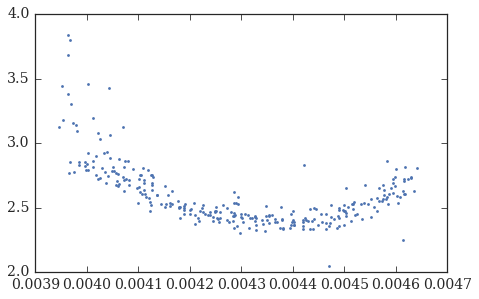

In [26]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'],myDataFrame['WS_sigma_y'],'.')

In [27]:
myDataFrame['WS_emittance_y'] = myDataFrame['WS_sigma_y'].apply(lambda x: normalised_emittance_y(x))

(0.0039000000000000003, 0.0047000000000000002, 0.7, 2)

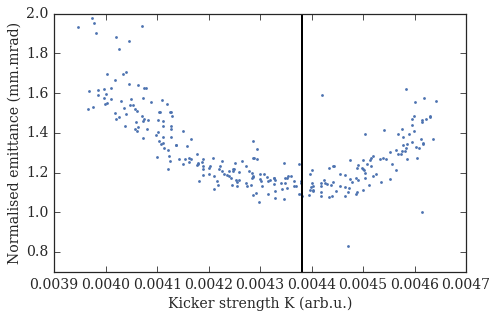

In [28]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'],myDataFrame['WS_emittance_y'],'.')
plt.xlabel('Kicker strength K (arb.u.)')
plt.ylabel('Normalised emittance (mm.mrad)')
plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,.7,2))
# IMPORTANT NOTE: the gaussian smears out at low kicker strenghts --> error on the emittance is bigger 

### X plane

In [29]:
myDataFrame['WS_emittance_x'] = np.nan

for n in range(len(myDataFrame)):
    myDataFrame['WS_emittance_x'].iloc[n] = normalised_emittance(myDataFrame['WS_sigma_x'].values[n],myDataFrame['deltaP_P_rms'].values[n])

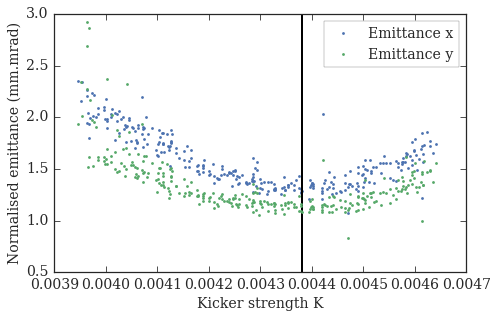

In [51]:
Emittance_x, = plt.plot(myDataFrame['logical_PI_KFA45.K.value'],myDataFrame['WS_emittance_x'],'.',label='Emittance x')
plt.xlabel('Kicker strength K')
plt.ylabel('Normalised emittance (mm.mrad)')
plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')
# set axis to get rid of some bad shots
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.,2.5))


Emittance_y, = plt.plot(myDataFrame['logical_PI_KFA45.K.value'],myDataFrame['WS_emittance_y'],'.',label='Emittance y')

legend = plt.legend(handles=[Emittance_x,Emittance_y],frameon=True)

plt.show()

In [31]:
Emittance_x, = plt.plot(myDataFrame['OrbitX_dev_RMS'], myDataFrame['WS_emittance_x'],'.',label='x plane')
plt.xlabel('RMS orbit deviation (mm)')
plt.ylabel('Normalised emittance (mm.mrad)')

Emittance_y, = plt.plot(myDataFrame['OrbitY_dev_RMS'], myDataFrame['WS_emittance_y'],'.',label='y plane')

legend = plt.legend(handles=[Emittance_x,Emittance_y],frameon=True)
# set axis to get rid of some bad shots
x1,x2,y1,y2 = plt.axis()
plt.axis((0,8,1,2.5))

KeyError: 'OrbitX_dev_RMS'

In [46]:
plt.plot(myDataFrame['deltaX_2turns'], myDataFrame['WS_emittance_x'],'.')
plt.xlabel('RMS X orbit deviation (mm)')
plt.ylabel('Normalised emittance (mm.mrad)')

# set axis to get rid of some bad shots
x1,x2,y1,y2 = plt.axis()
plt.axis((0,8,1,2.5))

KeyError: 'deltaX_2turns'

(0.0039000000000000003, 0.0047000000000000002, 1.1, 2.5)

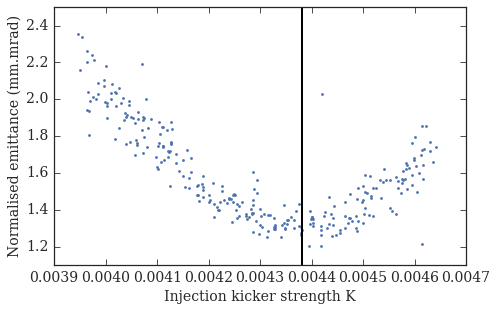

In [47]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'], myDataFrame['WS_emittance_x'],'.')
plt.xlabel('Injection kicker strength K')
plt.ylabel('Normalised emittance (mm.mrad)')
plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')
# set axis to get rid of some bad shots
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,1.1,2.5))

(0.0039000000000000003, 0.0047000000000000002, 4, 5.8)

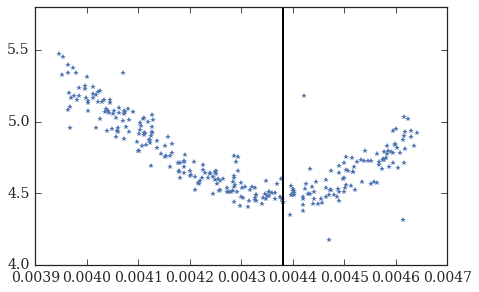

In [48]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'],myDataFrame['WS_sigma_x'],'*')
plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,4,5.8))

In [49]:
plt.plot(((myDataFrame['OrbitX_dev_RMS'].values)**2),  (myDataFrame['WS_emittance_x'])/1.3,'*')

plt.xlabel('RMS orbit deviation (mm)')
plt.ylabel('EmittanceX / Ref Emitance')

x1,x2,y1,y2 = plt.axis()
# plt.axis((-2,35,-0.2,1))

# plt.plot([-2,15],[-2/(4.5**2),15*(22./18)/(4.5)**2],'k-')  #22/18 is average beta correction
# plt.plot([0,30],[0,15/(4.5)**2],'r-')

plt.show()


KeyError: 'OrbitX_dev_RMS'

## Fittings

In [32]:
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy.optimize import leastsq

In [33]:
# data 
xdata = myDataFrame['logical_PI_KFA45.K.value'].values
ydata = myDataFrame['WS_emittance_x'].values

Model function: a+b|x+c|
Fit params: a=1.21022047 b= 2006.79571883 c= -0.00438203351934


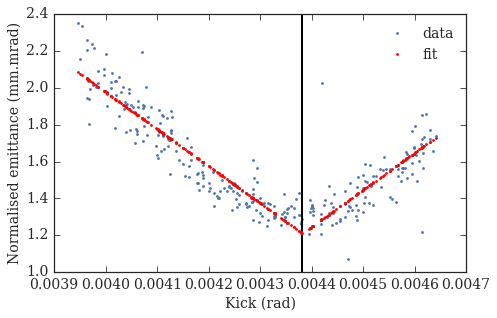

In [34]:
# homemade least square fit
def absFun(x, a, b, c):
    return a + b*np.abs(x+c)

def residual(p, x, y):
    return y - absFun(x, *p)
# initial params
p0 = [1.2, 800., -0.00438]
# fit
popt, pcov = leastsq(residual, p0, args=(xdata, ydata))

#plot data
plt.plot(xdata, ydata, '.',label='data')
plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

#fit and plot fit
print 'Model function: a+b|x+c|'
print 'Fit params: a=' + str(popt[0]) + ' b= ' + str(popt[1]) + ' c= '+ str(popt[2])
plt.plot(xdata, absFun(xdata, *popt), 'r.', label='fit')

plt.xlabel('Kick (rad)')
plt.ylabel('Normalised emittance (mm.mrad)')
plt.legend()

## Comparison to theory

In [35]:
shiftVal=0

Model function: a(x - b)^2 + c
Fit params: a=4.99681604554 b= 0.00437287465996 c= 1.35149109642e-06


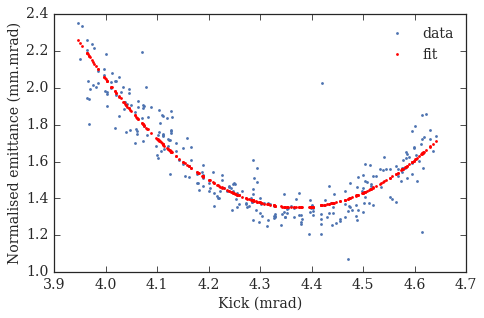

In [36]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, b, c):
    return a*(x - b)**2 + c

xdata = myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal)[1:]
ydata = 1e-6*myDataFrame['WS_emittance_x'].values[1:]

plt.plot(1e3*xdata, 1e6*ydata,'.',label='data') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)
plt.plot(1e3*xdata, 1e6*f_to_fit(xdata, *p), 'r.', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x - b)^2 + c'
print 'Fit params: a=' + str(p[0]) + ' b= ' + str(p[1]) + ' c= '+ str(p[2])


plt.xlabel('Kick (mrad)')
plt.ylabel('Normalised emittance (mm.mrad)')
plt.legend()

Model function: a(x - b)^2 + c
Fit params: a=2.20185630821 b= 0.0043728746599 c= 5.95537071287e-07


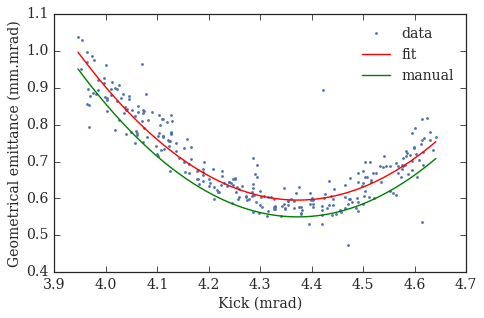

In [37]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, b, c):
    return a*(x - b)**2 + c

xdata = myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal)[1:]
ydata = 1e-6*myDataFrame['WS_emittance_x'].values[1:]/2.2693651855811541

plt.plot(1e3*xdata, 1e6*ydata,'.',label='data') #factors are to adjust units in the plot

xfit = np.linspace(np.min(xdata), np.max(xdata),200)

p, cov = curve_fit(f_to_fit,xdata,ydata)
plt.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x - b)^2 + c'
print 'Fit params: a=' + str(p[0]) + ' b= ' + str(p[1]) + ' c= '+ str(p[2])

plt.plot(1e3*xfit, 1e6*(p[0]*(xfit-p[1])**2 + 0.55e-6), 'g-', label='manual') #factors are to adjust units in the plot

plt.xlabel('Kick (mrad)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.legend()

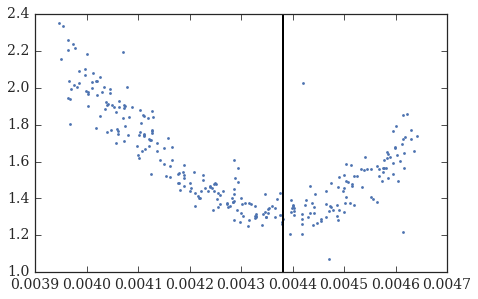

In [38]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'],myDataFrame['WS_emittance_x'],'.')
plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,2.3,2.6))

In [39]:
print myDataFrame['WS_emittance_x'].min()
ts_min = myDataFrame['WS_emittance_x'].idxmin()
print ts_min
print myDataFrame['logical_PI_KFA45.K.value'].loc[ts_min]
# myDataFrame = myDataFrame.drop(ts_min)

1.07303965575
2017-08-15 13:00:35.500000
0.00447


(0.0039000000000000003, 0.0047000000000000002, 1.0, 2.4000000000000004)

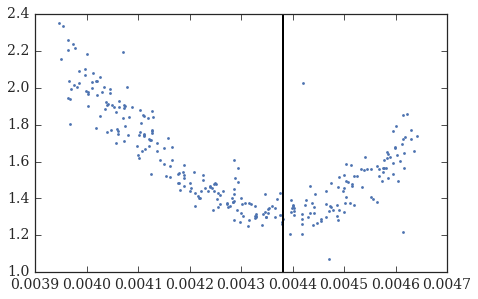

In [40]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'],myDataFrame['WS_emittance_x'],'.')
plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')
# x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,y2))

In [41]:
# pick the data with the smallest emittance
min_ts = myDataFrame['WS_emittance_x'].idxmin()

emiMin = myDataFrame['WS_emittance_x'].loc[min_ts]
sigmaMin = myDataFrame['WS_sigma_x'].loc[min_ts]

x = (myDataFrame['OrbitX_dev_RMS'].values / sigmaMin)**2
y = (myDataFrame['WS_emittance_x']/2.2693651855811541)/params[1]

params, cov_mat = np.polyfit(x,y,1,full=False,cov=True)

#plotting
plt.plot(x, y,'*')
plt.xlabel('\Delta_{RMS orbit deviation} / \sigma')
plt.ylabel('Relative X emittance change')

plt.plot(x, params[0]*x+params[1],'r')
print 'fit result: y=' + str(params[0]) + 'x + '+ str(params[1])

#plot theoretical behaviour
plt.plot(x, 0.5/16 *x+1,'g')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,2.2))

plt.show()


KeyError: 'OrbitX_dev_RMS'

In [42]:
# pick the data with the smallest emittance
min_ts = myDataFrame['WS_emittance_x'].idxmin()

emiMin = myDataFrame['WS_emittance_x'].loc[min_ts]
sigmaMin = myDataFrame['WS_sigma_x'].loc[min_ts]

x = (myDataFrame['OrbitX_dev_RMS'].values / sigmaMin)**2
x = (myDataFrame['OrbitX_dev_RMS'].values )**2
y = (myDataFrame['WS_emittance_x']/2.2693651855811541)


params, cov_mat = np.polyfit(x,y,1,full=False,cov=True)

#plotting
plt.plot(x, y,'*')
plt.xlabel('\Delta_{RMS orbit deviation} / \sigma ^2')
plt.ylabel('Geomtrical x emittance ')

plt.plot(x, params[0]*x+params[1],'r')
print 'fit result: y=' + str(params[0]) + 'x + '+ str(params[1])
print '---'
print 'normalised e_0=' + str(params[1]*2.2693651855811541)
print '1/2beta= ' + str(1/(2.*16))

# #plot theoretical behaviour
# plt.plot(x, 0.5/16 *x+1,'g')

x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,2.2))

plt.show()


KeyError: 'OrbitX_dev_RMS'

In [ ]:
plt.plot(((myDataFrame['OrbitX_dev_RMS'].values)**2),  (myDataFrame['WS_emittance_x']-1.3)/1.3,'*')

plt.plot(((myDataFrame['OrbitX_dev_RMS'].values)**2),  (myDataFrame['WS_emittance_y']-1.15)/1.15,'*')

plt.xlabel('Deviation from closed orbit RMS (mm) ^2')
plt.ylabel('Relative emittance change')

x1,x2,y1,y2 = plt.axis()
plt.axis((-2,35,-0.2,1))

# plt.plot([-2,15],[-2/(4.5**2),15*(22./18)/(4.5)**2],'k-')  #22/18 is average beta correction
# plt.plot([0,30],[0,15/(4.5)**2],'r-')

plt.show()

In [ ]:
plt.plot(myDataFrame['peakLineDensity'],'.')

## Lasett tune shift

In [43]:
# brightness and intensity
myDataFrame['WS_intensity'] = myDataFrame['Intensity'].apply(lambda x: x[80])
myDataFrame['Brightness'] = myDataFrame['WS_intensity']/(0.5*(myDataFrame['WS_emittance_x']+myDataFrame['WS_emittance_y']))

In [44]:
twiss_file_name = '/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23_cycled_timefalse.outx'

[deltaQx, deltaQy] = laslett_sc_PS(myDataFrame['peakLineDensity'], myDataFrame['deltaP_P_rms'],
              1e-6*myDataFrame['WS_emittance_x'], 1e-6*myDataFrame['WS_emittance_y'],
              1400, twiss_file_name)

myDataFrame['deltaQx'] = deltaQx
myDataFrame['deltaQy'] = deltaQy

In [53]:
myDataFrame['peakLineDensity']

2017-08-15 12:40:37.900    1.241595
2017-08-15 12:41:05.500    1.231887
2017-08-15 12:41:21.100    1.308626
2017-08-15 12:41:48.700    1.214458
2017-08-15 12:42:04.300    1.239352
2017-08-15 12:42:31.900    1.253390
2017-08-15 12:42:47.500    1.257519
2017-08-15 12:43:15.100    1.266236
2017-08-15 12:43:30.700    1.244055
2017-08-15 12:43:58.300    1.223770
2017-08-15 12:44:13.900    1.256667
2017-08-15 12:44:41.500    1.255492
2017-08-15 12:44:57.100    1.258502
2017-08-15 12:45:24.700    1.241420
2017-08-15 12:45:40.300    1.223387
2017-08-15 12:46:07.900    1.239341
2017-08-15 12:46:23.500    1.246501
2017-08-15 12:46:49.900    1.249276
2017-08-15 12:47:09.100    1.251475
2017-08-15 12:47:40.300    1.228205
2017-08-15 12:47:59.500    1.243985
2017-08-15 12:48:30.700    1.247388
2017-08-15 12:48:49.900    1.242312
2017-08-15 12:49:21.100    1.231227
2017-08-15 12:49:40.300    1.249431
2017-08-15 12:50:11.500    1.244048
2017-08-15 12:50:30.700    1.213722
2017-08-15 12:51:01.900    1

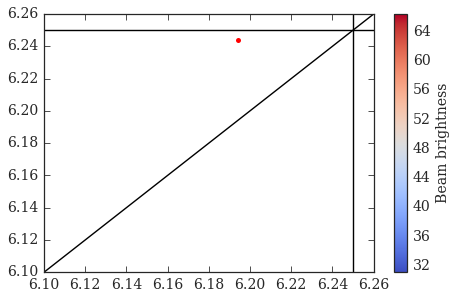

In [45]:
fig, ax = plt.subplots(1)

# working point
Qx = 6.194
Qy = 6.244
plt.plot(Qx,Qy,'r.',markersize=10)

# tune diagram lines
ax.plot([5.8, 6.3],[5.8, 6.3],'k')
ax.plot([6, 6],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6, 6],'k')
ax.plot([6.25, 6.25],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6.25, 6.25],'k')
# options
plt.xlim([6.1, 6.26])
plt.ylim([6.1, 6.26])
# tune shifts


p1 = ax.scatter(Qx+myDataFrame['deltaQx'], Qy+myDataFrame['deltaQy'], c=myDataFrame['Brightness'], cmap=plt.cm.coolwarm)
clb = fig.colorbar(p1)
clb.set_label('Beam brightness')

plt.show()

## Export the data

In [ ]:
myDataFrame['WS_intensity'] = myDataFrame['Intensity'].apply(lambda x: x[80])

In [ ]:
myDataFrame[['logical_PI_KFA45.K.value','peakLineDensity','WS_emittance_x','WS_emittance_y','deltaP_P_rms','WS_intensity']].to_csv('dataFrameExported.csv')

## KFA45 power supply linearity check

In [ ]:
plt.plot(myDataFrame['PI_KFA45.CCV.value'],myDataFrame['PI_KFA45.AQN1.value'],'.')